In [1]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

import warnings
warnings.filterwarnings("ignore")

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
''')

![title](figs/title.png)

<h1><center>Module 10: Numerical Solutions to Hyperbolic PDEs</center></h1>

This module focuses on generating numerical solutions of **hyperbolic** partial differential equations (PDEs).  Recall that these types of second-order PDEs

$$Au_{xx}+2Bu_{xy}+Cu_{yy}+Du_{x}+Eu_{y}+Fu+G=0 \tag{1}$$

are defined by the condition $B^2-AC > 0$ (where $y$ is considered the $t$ variable and thus $A=1$, $C=-\frac{1}{c}$ and all others are equal 0).

Three interesting examples (with increasing complexity) are the following:

   * **Acoustic wave equation (Homogeneous medium)**: The acoustic wave equation (AWE) is normally used to model the pressure disturbance $\phi=\phi(x,y,z,t)$ generated by an acoustic wave propagation through a fluid medium defined by constant velocity $v=\sqrt{\frac{K}{\rho}}$ where $K$ is the bulk compressibility and $\rho$ is the density.
   
$$\frac{\partial^2 \phi}{\partial t^2} - v^2\nabla^2 \phi = F(x,y,z,t) \tag{2}$$ 

where $F(x,y,z,t)$ is an external force term.  Note that the acoustic wave equation is commonly used in exploration seismology to approximate compressional (i.e., P-wave) propagation through complex heterogeneous media.
   
   * **Acoustic wave equation (variable density)**: This is like the example above, except now that the density, $\rho$, is assumed to spatially vary:

$$\frac{\partial^2 \phi}{\partial t^2}  -  K \nabla \cdot \left(\frac{1}{\rho} \nabla \phi  \right) = F(x,y,z,t), \tag{3}$$ 
   
where $K$ is the bulk compressability.  This equation is commonly used in computational ocean acoustics because it allows one to introduce variations in density caused by temperature and salinity concentration among others.  This wave equation requires the same type of initial and boundary conditions as the homogenous equation above.


   * **One-way wave equations**:  We have actually looked at this hyperbolic equation in Module 7 of the course. One can recognize this to be the case if we **factorize** the 1D AWE given above in the following way
   
$$\left[\frac{\partial^2 }{\partial t^2} - v^2\frac{\partial}{\partial x^2} \right] \phi = 
\left(\frac{\partial }{\partial t}-v \frac{\partial}{\partial x} \right)\left( \frac{\partial }{\partial t}+v \frac{\partial}{\partial x}\right) \phi = F(x,t). \tag{4}$$ 
Here we see that we have the produce of the left- and right-going advection equations. This was recognized in 1747 by French scientist [d'Alembert](https://en.wikipedia.org/wiki/D%27Alembert%27s_formula).  Note that one sometimes see the **d'Alembert operator** $\Box^2$ in various problems in mathematical physics, which is given by the following in Cartesian coordinates:

$$\Box^2 \phi = \left[\frac{\partial^2 }{\partial t^2} - v^2\frac{\partial}{\partial x^2} \right] \phi\tag{5}$$

### Initial and Boundary Conditions

Because this is a **second-order** temporal partial derivative, uniquely defining a wavefield solution requires implementing **two initial conditions** that define the wavefield at, say, time zero: 

$$\phi(x,y,z,t=0)=f(x,y,z) \tag{6}$$ 

as well as its derivative. 

$$\frac{\partial \phi}{\partial t}(x,y,z,t=0) = g(x,y,z).\tag{7}$$

One also has to prescribe the behavior of the wavefield solution on the domain boundary $D$ (e.g., $\left. \phi\right|_{\partial D}=B(x,y,z)$). In some circumstances, one may want to apply a Dirchelet BC

$$ \phi(\mathbf {x}) = f(\mathbf {x}), \quad \forall \mathbf {x}\in \delta \Omega \tag{8}$$

where one sets $f(x)=0$ to obtain an inward moving reflected wave with the oppositing polarity. This is commonly used for waves approaching the free surface of a fluid acoustic medium.  However, in most other circumstances one wants to have perfectly absorbing boundary conditions such that no energy is reflected back into the finite-sized computational domain. These are the so-called (Sommerville) radiation boundary conditions which require the wave disturbance to vanish at infinity in an unbounded medium.  This topic, though, remains an active area of research and goes well beyond the scope of this course.

# 1D Acoustic wave equation

Let's first look at the problem of an acoustic wave propagating on a 1D medium.  Because of the easy connection with everyday experience, let's assume examine the propagation of a wave on a homogeneous taut string of length $L$ where both of the string ends and fixed. In this case, we can assume that there is no external forcing function (i.e., $F(x,t)=0$) and the string starts from some combination of an initial displacement disturbance $\phi(x,t=0) = f(x)$ and an initial velocity $\frac{\partial \phi}{\partial t}(x,t=0) = g(x)$. Thus, the PDE we are solving is

$$\frac{\partial^2 \phi}{\partial t^2} = v^2\frac{\partial^2 \phi}{\partial x^2}. \tag{9}$$ 

Let's now look at an **explicit** discretization method to solve equation 9 (as opposed to the **implicit** ones like Crank-Nicolson approach we studied in Module 9).  Let's start by using a standard **centered in time centered in space** (CTCS) $\mathcal{O}(\Delta x^2,\Delta t^2)$ discretization:

$$\frac{\phi^{n+1}_i - 2\phi^{n}_i +\phi^{n-1}_i}{\Delta t^2} = 
v^2 \left( \frac{\phi^{n}_{i+i} - 2\phi^{n}_i +\phi^{n}_{i-1}}{\Delta x^2} \right). \tag{10}$$

Let's now multiply through by $\Delta t^2$ and use the square of the Courant number $C^2 = \frac{v^2\Delta t^2}{\Delta x^2}$ from the previous modules to write:

$$\phi^{n+1}_i - 2\phi^{n}_i +\phi^{n-1}_i = C^2 \left( \phi^{n}_{i+i} - 2\phi^{n}_i +\phi^{n}_{i-1}\right). \tag{11}$$

Rearranging terms to isolate the unknown quantity at time step $n+1$ on the left-hand side and keeping the known quantities on the right-hand side leads to:

$$\phi^{n+1}_i = 2\phi^{n}_i -\phi^{n-1}_i +C^2 \left(\phi^{n}_{i+i} -2 \phi^{n}_i + \phi^{n}_{i-1}\right). \tag{12}$$

You may note that one could combine the $\phi^n_i$ terms into a more compact stencil. However, I am avoiding doing this because we will look at higher-order  finite-difference expansions of the spatial second partial derivative in sections below 

### Initial Conditions

Above we noted that two initial conditions are required for this PDE because of the second temporal derivative. However, based on the above discretization it may not be apparent how the derivative initial condition can be introduced.  One thing to note is that the discretization now contains term $\phi^{n-1}_i$, which represents the wavefield at the previous time step. Thus, this can be used to set the second condition by:

$$\frac{\partial \phi}{\partial t} \approx \frac{\phi^n_i - \phi^{n-1}_i}{\Delta t} = g(x).  \tag{13}$$

The common assumption is that the wavefield is **quiescent** (i.e., no energy) at time steps $n=0$ and $n=-1$. This means that $g(x)=0$ in equation 13 and thus $\phi^0_i=\phi^{-1}_i=0$.  However, in cases where we have $g(x)\neq 0$ then we can use a  finite-difference approximation to specify the wavefield at the previous time step as

$$\phi^{n-1}_i = \phi^n_i-\Delta t g(x).\tag{14}$$

Alternatively, it may also be possible that $\phi^{n-1}_i$ is known analytically and can just be stated (e.g., it is a translation of the waveform at $\phi^n_i$.

### Handling Boundaries with Ghost Points

We can also explore what happens at the left and right boundaries from equation 12.  At the left hand boundary (i.e., $i=0$) we can write

$$\phi^{n+1}_1 = 2\phi^{n}_1 -\phi^{n-1}_1 +C^2 \left(\phi^{n}_{2} -2 \phi^{n}_1 + \phi^{n}_{0}\right). \tag{14}$$

Note that there is a $ \phi^{n}_{0}$ term in this equation.  Currently, we are able to handle this because we can use the Dirchelet boundary condition to set this point equal to zero.  However, if we were to use higher-order finite-difference stencils for our second derivative, these would require using additional points such as $\phi^n_{-1}$ which represent a point falling out of the grid! Let's assume that we can set $ \phi^{n}_{-1}=0$ (as well those with an increasing negative index).  This is termed using **ghost points** which are not formally defined, but are conjured up for numerical expediency.  Similarly, on the right-hand side we will have to do the same at ghost point $ \phi^{n}_{N+1}=0$ as well as those with greater indices.

## 1D AWE Solver

Given this machinary, we can now adapt the types of solvers we constructed in the previous modules to the current scenario. Let's first build a 1D AWE solver of $\mathcal{O}(\Delta x^2,\Delta t^2)$ that is appropriate for homogeneous medium where $v$=const.

In [31]:
def awe_explicit_solver_homogeneous_2nd_order(Wo,Wm,dx,dt,v):
    '''Set up second-order solver of the acoustic wave equation
    usage: U = awe_explicit_solver_homogeneous(Wo,Wm,dx,dt,v)
    input: 
        Wo: Acoustic pressure vector (nx) at time step n
        Wm: Acoustic pressure vector (nx) at time step n-1
        dx: Spatial sampling (float)
        dt: Temporal sampling (float)
        v : Homogeneous propagation velocity (float)
    output:
        Wm: Acoustic pressure vector (nx) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions of wavefield
    nx = len(Wo)
    
    ## . . Define Courant number (squared)
    C2 = (v*dt/dx)**2
        
    ## . . Update solution. Note that I am overwriting Wm because this wavefield
    ## . . isn't needed after this calculation!
    Wm[1:nx-1] = 2*Wo[1:nx-1]-Wm[1:nx-1]+C2*(Wo[2:nx]-2*Wo[1:nx-1]+Wo[0:nx-2])

    return Wm ## . . Return updated wavefield at time step n+1

Let's now build up a scenario that we are trying to model.  I will assume that the length of the region to be modeled is $L=1000$ mm, that is discretized into $nx=201$ (and thus $\Delta x = 5$ mm segments), and the velocity is $v=1000$ mm/s. 

In [32]:
## . . Define spatial grid
L  = 1000               # . . String length (mm)
nx = 201                # . . Number of points in discretization 
dx = L/(nx-1)           # . . Discretization interval
x = np.linspace(0,L,nx) # . . Xline
v  = 1000               # . . Velocity (mm/s)

Let's now define the time stepping conditions.  Because we have define our $\Delta x$ and $v$, we know that we need to obey the following Courant condition for stability (usually called the CFL condition):

$$C \equiv \frac{v \Delta t}{\Delta x} \le 1. \tag{15}$$

Thus, let's be a bit conservative and choose $C=0.5$.  Thus, we can set our $\Delta t$ time step parameter to satisfy the CFL condition:

$$ \Delta t = \frac{0.8\Delta x}{v} = \frac{0.8 \times 5 {\rm mm}}{1000 {\rm mm/s}} = 0.004 {\rm ms}. \tag{16}$$

We also want to define our two initial conditions, which we we assume to have the shape of a stationary Ricker wavelet with no prior velocity:

$$\phi(x,t=0) = f(x) = \frac{2}{\sqrt{3\sqrt{\pi}}} \left(1 - ((x-3L/4)/\sigma)^2\right)e^{-\frac{(x-3L/4)^2}{2\sigma^2}}\tag{17}$$

and 

$$\left.\frac{\partial \phi}{\partial t}\right|_{t=0} = g(x) = 0  \rightarrow \phi^{n-1}_i=0 \tag{18}$$

where the right arrow shows the impliction that the $n-1$ time step is zero.  For this simulation we will use $\sigma=40$, though this will be varied in the section below. Let's now compute the solution

In [34]:
## . . Time stepping parameters
CC = 0.5     # . . Courant #
nt = 800     # . . Number of time steps
dt = CC*dx/v # . . Define dt based on Courant

## . . Define Initial waveform
ss=40        # . . sigma for Ricker wavelet

## . . Init wavefields on spatial grid
Up = np.zeros((nx))
Uo = np.zeros((nx))
Um = np.zeros((nx))

## . . Define initial disturbance
Uo = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4)/ss)**2)*np.exp(-(x-3*L/4)**2/(2*ss**2))

## . . Total Solution space
c = np.zeros((nx,nt)) 

## . . Iterate over solution time steps
for it in range(nt):
    tmp = awe_explicit_solver_homogeneous_2nd_order(Uo,Um,dx,dt,v) #calc solution at n+1
    c[:,it]=tmp  ## save solution vector
    Um=Uo        ## move solution at n to n-1 to prepare for next iteration
    Uo=tmp       ## move solution at n+1 to n to prepare for next iteration

amax = np.max(np.abs(c))

## . . 1D animation fucntion
def AWE_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(x,c[:,k],color='cyan',linewidth=3)
    ax1.grid(True)
    ax1.set_xlim([0,L])
    ax1.set_ylim([-1.1*amax,1.1*amax])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip
    
k = 0
kskip = 4

## . . Set up movie
fig1,ax1 = plt.subplots(1)
fig1.subplots_adjust(0.1,0.1,0.9,0.9)
fig1.set_dpi(100)

## . . Call the animator.  
anim1 = animation.FuncAnimation(fig1,AWE_1D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim1.save('./movies/Ex8_1.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_1.mp4" type="video/mp4">
</video>
""")

**Figure 1. Illustration of wave equation solution when one only defines the wavefield $\phi(x,t=0)$ and $\phi(x,t=-\Delta t)=0$. Note that there is a two-way solution because  we have not specified a constraint forcing the solution to propagate one way or the other (see below).**

Let's now look at what happens when we specify the previous wavefield state at $\phi(x,t=-\Delta t)$, which requires establishing what the wave looks like at the previous time step. Given the initial Ricker wavelet above, it is reasonable to expect that the wavefield solution at $\phi(x,t=-\Delta t)$ will be given by some wavefield shift $t_0$:

$$\phi(x,t=-\Delta t) = \frac{2}{\sqrt{3\sqrt{\pi}}} \left(1 - ((x-3L/4-v\Delta t )/\sigma)^2\right)e^{-\frac{(x-3L/4-v\Delta t)^2}{2\sigma^2}}, \tag{19}$$

where $t_0=v\Delta t$ has been introduced to account for a spatial shift.  Let's rerun the solution from above, but now where we set the value of $\phi^{n-1}_i$ as non-zero: 

In [5]:
## Time stepping parameters
CC = 0.5     # . . Courant #
nt = 800     # . . Number of time steps
dt = CC*dx/v # . . Define dt based on Courant

## . . Define Initial waveform
ss=40        # . . sigma for Ricker wavelet

## . . reinit wavefields on spatial grid
Up = np.zeros((nx))
Uo = np.zeros((nx))
Um = np.zeros((nx))

## . . Define initial time solution at t=0
Uo = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4     )/ss)**2)*np.exp(-(x-3*L/4     )**2/(2*ss**2))

## . . Define previous time step at t=-∆t
Um = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4-dt*v)/ss)**2)*np.exp(-(x-3*L/4-dt*v)**2/(2*ss**2))

## . . Total Solution space
c = np.zeros((nx,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_explicit_solver_homogeneous_2nd_order(Uo,Um,dx,dt,v) #calc solution at n+1
    c[:,it]=tmp  ## save solution vector
    Um=Uo        ## move solution at n to n-1 to prepare for next iteration
    Uo=tmp       ## move solution at n+1 to n to prepare for next iteration
    
amax = np.max(np.abs(c))

## . . 1D animation fucntion
def AWE_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(x,c[:,k],color='cyan',linewidth=3)
    ax1.grid(True)
    ax1.set_xlim([0,L])
    ax1.set_ylim([-1.1*amax,1.1*amax])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip
    
k = 0
kskip = 4

## . . Set up movie
fig2,ax1 = plt.subplots(1)
fig2.subplots_adjust(0.1,0.1,0.9,0.9)
fig2.set_dpi(100)

## . . Call the animator.  
anim2 = animation.FuncAnimation(fig2,AWE_1D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim2.save('./movies/Ex8_2.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_2.mp4" type="video/mp4">
</video>
""")

**Figure 2. Illustration of wave-equation solution when defining the wavefield at $t=0$ and $t=-\Delta t$.  Note that the wave initially travels to the left instead of both directions like in Figure 10.1 above.**

Parameter $\sigma$ is of course related to the **frequency** content of the Ricker wavelet. Let's now investigate what happens when we set $\sigma=15$ instead of using $\sigma=40$ as we did in the simulations above:

In [6]:
## Time stepping parameters
CC = 0.5     # . . Courant #
nt = 500     # . . Number of time steps
dt = CC*dx/v # . . Define dt based on Courant

## . . Define Initial waveform
ss = 15      # . . sigma for Ricker wavelet

## . . Init wavefields on spatial grid
Up = np.zeros((nx))
Uo = np.zeros((nx))
Um = np.zeros((nx))

## . . Define wavefield at t=0
Uo = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4     )/ss)**2)*np.exp(-(x-3*L/4     )**2/(2*ss**2))

## . . Define wavefield at t=-∆t
Um = 2/np.sqrt(3*ss*np.sqrt(np.pi))*(1-((x-3*L/4-dt*v)/ss)**2)*np.exp(-(x-3*L/4-dt*v)**2/(2*ss**2))

## . . Total Solution space
c = np.zeros((nx,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_explicit_solver_homogeneous_2nd_order(Uo,Um,dx,dt,v) #calc solution at n+1
    c[:,it]=tmp  ## save solution vector
    Um=Uo        ## move solution at n to n-1 to prepare for next iteration
    Uo=tmp       ## move solution at n+1 to n to prepare for next iteration
    
amax = np.max(np.abs(c))

## . . 1D animation fucntion
def AWE_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(x,c[:,k],color='cyan',linewidth=3)
    ax1.grid(True)
    ax1.set_xlim([0,L])
    ax1.set_ylim([-1.1*amax,1.1*amax])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip
    
k = 0
kskip = 4

## . . Set up movie
fig3,ax1 = plt.subplots(1)
fig3.subplots_adjust(0.1,0.1,0.9,0.9)
fig3.set_dpi(100)

## . . Call the animator.  
anim3 = animation.FuncAnimation(fig3,AWE_1D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim3.save('./movies/Ex8_3.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_3.mp4" type="video/mp4">
</video>
""")

**Figure 3. Illustration of how numerical dispersion can degrade the solution over time.  The initial wave packet starts to develop a long "tail" that represents non-physical dispersive behaviour.**

## Higher-order derivatives

It's clear that the numerical solution behavior noted in Figure 3 is less than idea.  Thus, we need to look at different methods for trying to eliminate these artifacts. One strategy would be to use a smaller $\Delta x$, which is easy to do in a 1D solution because the computational cost scales according to $\mathcal{O}(N)$ where $N$ is the number of points. However, in 3D this approach would scale according to $\mathcal{O}(N^3)$ since we would have to apply it in each dimension!  This would significantly affect our computational efficiency. 

Another strategy would be to use higher-order spatial derivatives, which we we know lead to a more accurate representation of numerical derivatives. To do this, let's rewrite the 1D solver for homogeneous media from above to incorporate an $\mathcal{O}(\Delta x^8)$ centered approximation of the second-order spatial partial derivative.  This requires using a nine-point stencil that incorporates four points to the left and right of the  center point:

$$\phi^{n+1}_i = 2\phi^{n}_i -\phi^{n-1}_i +C^2 \left(-\frac{1}{560}\phi^{n}_{i+4}+\frac{8}{315}\phi^{n}_{i+3}-\frac{1}{5}\phi^{n}_{i+2}+\frac{8}{5}\phi^{n}_{i+1} -\frac{205}{72} \phi^{n}_i +\frac{8}{5} \phi^{n}_{i-1}-\frac{1}{5}\phi^{n}_{i-2}+\frac{8}{315}\phi^{n}_{i-3}-\frac{1}{560} \phi^{n}_{i-4}\right), \tag{20}$$

where these [finite-difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficient#Central_finite_difference) are for a **centered second derivative of $O(\Delta x^8)$**. 

Note that we will again have issues at the boundaries where we will need **ghost points**. However, because we have longer stencil, we will now need to have four ghost points instead of just one.  Let's see how this work in our solver:

In [7]:
def awe_explicit_solver_homogeneous_8th_order(Wo,Wm,dx,dt,v):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U = awe_explicit_solver_homogeneous(Wo,Wm,dx,dt,v)
    input: 
        Wo: Acoustic pressure vector (nx) at time step n
        Wm: Acoustic pressure vector (nx) at time step n-1
        dx: Spatial sampling
        dt: Temporal sampling
        v : Homogeneous propagation velocity 
    output:
        Wm: Acoustic pressure vector (nx) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions of wavefield
    nx = len(Wo)
    
    ## . . Define Courant number (squared)
    C2 = (v*dt/dx)**2
        
    ## . . Update solution. Note that I am overwriting Wm because this wavefield
    ## . . isn't needed after this calculation! I am also starting at index 4 (and ending)
    ## . . at index nx-4 because of the ghost points discussed above.
    Wm[4:nx-4] = 2*Wo[4:nx-4]-Wm[4:nx-4]+C2*( 
                    -1/560 *Wo[0:nx-8] 
                    +8/315 *Wo[1:nx-7]  
                    -1/5   *Wo[2:nx-6]  
                    +8/5   *Wo[3:nx-5]  
                    -205/72*Wo[4:nx-4]  
                    +8/5   *Wo[5:nx-3]  
                    -1/5   *Wo[6:nx-2]  
                    +8/315 *Wo[7:nx-1]  
                    -1/560 *Wo[8:nx  ])    
    
    return Wm ## . . Return updated wavefield at time step n+1

Let's now rerun our numerically dispersive example where we set $\sigma=15$ from above but using our $\mathcal{O}(\Delta x^8)$ solver for homogeneous media.

In [8]:
## Time stepping parameters
CC = 0.5     # . . Courant #
nt = 500     # . . Number of time steps
dt = CC*dx/v # . . Define dt based on Courant

## . . Define Initial waveform
ss=15        # . . sigma for Ricker wavelet

## . . Init wavefields on spatial grid
Up = np.zeros((nx))
Uo = np.zeros((nx))
Um = np.zeros((nx))

## . . Define wavefield at t=0
Uo = 2./np.sqrt(3.*ss*np.sqrt(np.pi))*(1-((x-3.*L/4.     )/ss)**2)*np.exp(-(x-3.*L/4.     )**2/(2*ss**2))

## . . Define wavefield at t=-∆t
Um = 2./np.sqrt(3.*ss*np.sqrt(np.pi))*(1-((x-3.*L/4.-dt*v)/ss)**2)*np.exp(-(x-3.*L/4.-dt*v)**2/(2*ss**2))

## . . Total Solution space
d = np.zeros((nx,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_explicit_solver_homogeneous_8th_order(Uo,Um,dx,dt,v) #calc solution at n+1
    d[:,it]=tmp  ## save solution vector
    Um=Uo        ## move solution at n to n-1 to prepare for next iteration
    Uo=tmp       ## move solution at n+1 to n to prepare for next iteration
    
amax = np.max(np.abs(d))

## . . 1D animation fucntion
def AWE_1D_animate(i):
    global k
    ax1.clear()
    ax1.plot(x,d[:,k],color='cyan',linewidth=3)
    ax1.grid(True)
    ax1.set_xlim([0,L])
    ax1.set_ylim([-1.1*amax,1.1*amax])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip
    
k = 0
kskip = 4

## . . Set up movie
fig4,ax1 = plt.subplots(1)
fig4.subplots_adjust(0.1,0.1,0.9,0.9)
fig4.set_dpi(100)

## . . Call the animator.  
anim4 = animation.FuncAnimation(fig4,AWE_1D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim4.save('./movies/Ex8_4.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_4.mp4" type="video/mp4">
</video>
""")

**Figure 4. As in Figure 3, but using the 8th-order solver for homogeneous media. Note that the previously noted "tail" has largely - but not completely - disappeared.  This indicates that the higher-order finite-difference approximation has helped to reduce numerical dispersion, but is not a panacea for this issue.**

It is also illustrative to plot the two previous solutions over top of each other. Note that because of the different number of ghost points used, the location of the boundary reflection will be at slightly different locations; thus, I'll only plot it up to the point where the waves reach the boundary.

In [9]:
k = 0
kskip = 4
amax = np.max(np.abs(d))
def AWE_1D_animate2(i):
    global k
    ax1.clear()
    ax1.plot(x,c[:,k],color='cyan',linewidth=3)
    ax1.plot(x,d[:,k],color='magenta',linewidth=3)
    ax1.legend(['2nd','8th'])
    ax1.grid(True)
    ax1.set_xlim([0,L])
    ax1.set_ylim([-1.1*amax,1.1*amax])
    ax1.set(xlabel='Distance (m)',ylabel='Amplitude')
    k += kskip

## . . Set up movie
fig5,ax1 = plt.subplots(1)
fig5.subplots_adjust(0.1,0.1,0.9,0.9)
fig5.set_dpi(100)

## . . Call the animator.  
anim5 = animation.FuncAnimation(fig5,AWE_1D_animate2,frames=int((nt-2*kskip)/kskip),interval=100)
anim5.save('./movies/Ex8_5.mp4')
plt.close()

HTML("""
<video width="500" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_5.mp4" type="video/mp4">
</video>
""")

**Figure 5. Comparison of the solutions generated by the eighth- and second-order solvers. The higher-order method clearly produces a more accurate result - though it is itself not perfect.**


# 2D Acoustic wave equation

Let's now look at the problem of an acoustic wave propagating through a homogeneous 2D domain. In this case, we can assume that there is an external forcing function $F(x,y,t)\neq0$ and the wave disturbance is initially zero in a **quiescent** state. Thus, the 2D PDE we are solving is

$$\frac{\partial^2 \phi}{\partial t^2} = v^2\left(\frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2} \right) + F(x,y,t). \tag{21}$$ 

One commmon thing that people use is to model the acoustic wavefield eminating from a spatially localized point source.  In these scenarios, one can write the following for the force source

$$F(x,y,t) = W(t)\delta(x-s_x)\delta(y-s_y), \tag{22}$$

where point ${\bf s}=[s_x,s_y]$ represents the coordinates of point source and $W(t)$ represents the wavelet to be **injected** into the domain. 

### Discretizing the 2D AWE

Let's now look at an **explicit** discretization method.  Let's use a $\mathcal{O}(\Delta x^8,\Delta t^2)$ discretization:

$$\frac{\phi^{n+1}_{i,j} - 2\phi^{n}_{i,j} +\phi^{n-1}_{i,j}}{\Delta t^2} = 
\frac{v^2}{\Delta x^2} \sum_{k=-4}^4 c_k \phi^{n}_{i+k,j}+ \frac{v^2}{\Delta y^2} \sum_{k=-4}^4 c_k \phi^{n}_{i,j+k} + F_{i,j}, \tag{23}$$

where $c_k$ are the finite-difference coefficients discussed above.  Let's now multiply through by $\Delta t^2$ and use the square of the Courant number $C_x^2 = \frac{v^2\Delta t^2}{\Delta x^2}$ and $C_y^2 = \frac{v^2\Delta t^2}{\Delta y^2}$ from the previous modules to write

$$\phi^{n+1}_{i,j} = 2\phi^{n}_{i,j} - \phi^{n-1}_{i,j} +
C_x^2 \sum_{k=-4}^4 c_k \phi^{n}_{i+k,j}+ C_y^2\sum_{k=-4}^4 c_k \phi^{n}_{i,j+k} +\Delta t^2 F_{i,j}. \tag{24}$$

This is pretty much the same as in 1D, so let's just move right to the 2D solver!

In [10]:
def awe_2d_explicit_solver_homogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U= awe_2d_explicit_solver_homogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F)
    input: 
        UUo: Acoustic pressure vector (nx,ny) at time step n
        UUm: Acoustic pressure vector (nx,ny) at time step n-1
        dx : Spatial sampling in x
        dy : Spatial sampling in y        
        dt : Temporal sampling
        v  : Homogeneous propagation velocity 
        F  : Forcing function (nt)
        it : Time index
        sx : Location of source in x (meters)
        sy : Location of source in y (meters)
    output:
        UUm: Acoustic pressure vector (nx,ny) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 11/2019
    '''        
    ## . . Get dimensions of wavefield
    nx,ny = np.size(UUo,0),np.size(UUo,1)
    
    ## . . Define Courant numbers (squared)
    Cx2,Cy2 = (v*dt/dx)**2,(v*dt/dy)**2
        
    ## Source location
    isx,isy = int(sx/dx),int(sy/dy) ## . . Force to be integer (note assumes model origin at [0,0])
 
    ## . . Inject wavelet
    UUo[isx,isy] += dt*dt*F[it]
    
    ## . . Update solution. Again, I am starting the array at index 4 and ending 
    ## . . at index nx-4 and ny-4 because of the ghost points
    UUm[4:nx-4,4:ny-4] =  2*UUo[4:nx-4,4:ny-4]-UUm[4:nx-4,4:ny-4]+Cx2*( 
                    -1/560 *UUo[0:nx-8,4:ny-4] 
                    +8/315 *UUo[1:nx-7,4:ny-4]  
                    -1/5   *UUo[2:nx-6,4:ny-4]  
                    +8/5   *UUo[3:nx-5,4:ny-4]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[5:nx-3,4:ny-4]  
                    -1/5   *UUo[6:nx-2,4:ny-4]  
                    +8/315 *UUo[7:nx-1,4:ny-4]  
                    -1/560 *UUo[8:nx  ,4:ny-4])+Cy2*( 
                    -1/560 *UUo[4:nx-4,0:ny-8] 
                    +8/315 *UUo[4:nx-4,1:ny-7]  
                    -1/5   *UUo[4:nx-4,2:ny-6]  
                    +8/5   *UUo[4:nx-4,3:ny-5]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[4:nx-4,5:ny-3]  
                    -1/5   *UUo[4:nx-4,6:ny-2]  
                    +8/315 *UUo[4:nx-4,7:ny-1]  
                    -1/560 *UUo[4:nx-4,8:ny  ])

    return UUm ## . . Return updated wavefield at time step n+1

You'll note that I've changed things a bit here since I am now **injecting the wavelet** into the 2D domain at the current time step $it$.  Here, I've calculated the location of the incidies $[isx,isy]$ at which to inject the wavelet.  I could have also created a force source term $F^n_{i,j}$ as a 3D array; however, this would be wasteful of memory since I'm only injecting at one location.

In [11]:
## . . Define spatial grid
Lx,Ly = 2000,2000           # . . length (m)
nx,ny = 401,401             # . . Number of points in discretization 
dx,dy = Lx/(nx-1),Ly/(ny-1) # . . Discretization interval
x ,y  = np.linspace(0,Lx,nx),np.linspace(0,Ly,ny) # . . Xline
v  = 1000        # . . Velocity (m/s)

## . . Meshgrid
yyy,xxx = np.meshgrid(x,y)

## . . Init wavefields on spatial grid
UUo,UUm = np.zeros((nx,ny)),np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5     # . . Courant #
nt,dt,t0 = 800,CC*dx/v,0.1       # . . Number of time steps, dt and wavelet shift
t  = np.linspace(0,nt*dt,nt)

## . . Define Initial waveform
ss=0.02 ## sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))
sx,sy=Lx/2,Ly/2

## . . Total Solution space
eee = np.zeros((nx,ny,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_2d_explicit_solver_homogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy) #calc solution at n+1
    eee[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration
    
amax = np.max(np.abs(eee))

In [12]:
## . . Animate Solution and compute error
k,kskip = 0,20

## . . Set up movie
fig6,ax1 = plt.subplots(1)
fig6.subplots_adjust(0.1,0.1,0.9,0.9)
fig6.set_dpi(100)

def AWE_2D_animate(i):
    global k
    x = eee[:,:,k]
    ax1.imshow(x,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.1*amax,vmax=0.1*amax)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('NUMERICAL Step %s'%k,fontsize=14)
    k += kskip

## . . Call the animator
anim6 = animation.FuncAnimation(fig6,AWE_2D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim6.save('./movies/Ex8_6.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_6.mp4" type="video/mp4">
</video>
""")

**Figure 6. Propagating 2D acoustic wavefield generated by the 8th-order finite-difference AWE solver.  Note that the reflections from the boundary are with the opposite sign.**

## Wavefields, surface seismic and VSP data

Since we have the full 3D volume of $[nx,ny,nt]$ it is possible to slice it in different ways. Figure 7 shows the 2D slice at a constant depth (a) representing a surface seismic data set  as well as a 2D slice taken a constant x-location (b) which would represent a vertical seismic profile (VSP) data set.

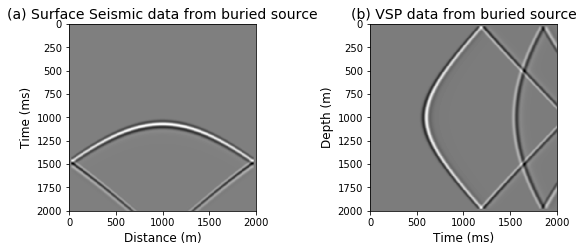

In [13]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.imshow(eee[5,:,:].T,cmap='gray',extent=[0,Lx,nt*dt*1000,0])
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Time (ms)',fontsize=12)
plt.title('(a) Surface Seismic data from buried source',fontsize=14)

plt.subplot(122)
plt.imshow(eee[:,int(nx/4),:],cmap='gray',extent=[0,Lx,nt*dt*1000,0])
plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Time (ms)',fontsize=12)
plt.title('(b) VSP data from buried source',fontsize=14)

plt.tight_layout()
plt.show()

**Figure 8. (a) Constant depth slice extracted 5m down from the first ghost point representing surface seismic data. (b) Constant X-location slice extracted at 500m distance representing a vertical seismic profile (VSP).**

## 2D Acoustic Wave Equation for Heterogeneous Media

While solutions of the 2D acoustic wave equation for homogeneous media are important for evaluating our finite-difference scheme, they have quite limited use in practice. This is because velocity models usually are heterogeneous: $v=v(x,y)$. Thus, we need to account for this spatial heterogeneity in our numerical solvers.  To do so, let's adapt our eight-order solver above to include heterogeneity. The most common practice in this situation would be to introduce a spatially varying velocity function into equation 24 above:

$$\phi^{n+1}_{i,j} = 2\phi^{n}_{i,j} - \phi^{n-1}_{i,j} +
\left(\frac{v_{i,j}\Delta t}{\Delta x}\right)^2 \sum_{k=-4}^4 c_k \phi^{n}_{i+k,j}+ \left(\frac{v_{i,j}\Delta t}{\Delta y}\right)^2\sum_{k=-4}^4 c_k \phi^{n}_{i,j+k} +\Delta t^2 F_{i,j}, \tag{25}$$

which leads to only a modest change in the *awe_2d_explicit_solver_heterogeneous_8th_order* solver below:

In [14]:
def awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U=awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy):
    input: 
        UUo: Acoustic pressure vector (nx,ny) at time step n
        UUm: Acoustic pressure vector (nx,ny) at time step n-1
        dx : Spatial sampling in x
        dy : Spatial sampling in y        
        dt : Temporal sampling
        v  : Heterogeneous propagation velocity (nx,ny)
        F  : Forcing function (nt)
        it : Time index
        sx : Location of source in x (meters)
        sy : Location of source in y (meters)
    output:
        UUm: Acoustic pressure vector (nx,ny) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions of wavefield
    nx,ny = np.size(UUo,0),np.size(UUo,1)
    
    ## . . Define Courant numbers (squared)
    dtdx2,dtdy2 = (dt/dx)**2,(dt/dy)**2
        
    ## Source location
    isx,isy = int(sx/dx),int(sy/dy) ## . . Force to be integer
 
    ## . . Inject wavelet
    UUo[isx,isy] += dt*dt*F[it]

    ## . . Update solution 
    UUm[4:nx-4,4:ny-4] =  2*UUo[4:nx-4,4:ny-4]-UUm[4:nx-4,4:ny-4]+dtdx2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[0:nx-8,4:ny-4] 
                    +8/315 *UUo[1:nx-7,4:ny-4]  
                    -1/5   *UUo[2:nx-6,4:ny-4]  
                    +8/5   *UUo[3:nx-5,4:ny-4]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[5:nx-3,4:ny-4]  
                    -1/5   *UUo[6:nx-2,4:ny-4]  
                    +8/315 *UUo[7:nx-1,4:ny-4]  
                    -1/560 *UUo[8:nx  ,4:ny-4])+dtdy2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[4:nx-4,0:ny-8] 
                    +8/315 *UUo[4:nx-4,1:ny-7]  
                    -1/5   *UUo[4:nx-4,2:ny-6]  
                    +8/5   *UUo[4:nx-4,3:ny-5]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[4:nx-4,5:ny-3]  
                    -1/5   *UUo[4:nx-4,6:ny-2]  
                    +8/315 *UUo[4:nx-4,7:ny-1]  
                    -1/560 *UUo[4:nx-4,8:ny  ])

    return UUm ## . . Return updated wavefield at time step n+1

Let's now generate a simple 1D velocity model that has a single reflector located at 250m depth.

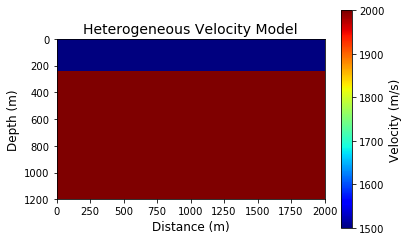

In [15]:
## . . Define spatial grid
Lx,Ly = 2000,1200           # . . lengths (m)
nx,ny = 401,241             # . . Number of points in discretization 
dx,dy = Lx/(nx-1),Ly/(ny-1) # . . Discretization intervals

## . . Create velocity function
v = np.zeros((nx,ny))+1500
v[:,50:]=2000

plt.figure()
plt.imshow(v.T,cmap='jet',extent=[0,Lx,Ly,0])
cbar=plt.colorbar()
cbar.set_label('Velocity (m/s)',fontsize=12)
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
plt.title('Heterogeneous Velocity Model',fontsize=14)
plt.show()

**Figure 9. Heterogeneous velocity model with a single discontinuity located at 250 m depth.**

Let's now call our solver for heterogeneous media:

In [16]:
## . . Init wavefields on spatial grid
UUo = np.zeros((nx,ny))
UUm = np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 800                     # . . Number of time steps
dt = CC*dx/np.max(v)         # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift 

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))

## . . Define source location
sx,sy=Lx/2,25                # . . source x,y location (in physical m units)

## . . Total Solution space
fff = np.zeros((nx,ny,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,v,F,it,sx,sy) #calc solution at n+1
    fff[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

## . . compute maximum for scaling
amax = np.max(np.abs(fff))

## . . Add (demeaned) velocity model to wavefield to illustrate interactions
vscale = (v.T-np.mean(v))
vscale = -vscale/np.max(vscale)

In [17]:
def AWE_2D_animate(i):
    global k
    wfld = fff[:,:,k].T/np.max(np.abs(fff))
    data = wfld+0.0025*vscale[:,::-1]
    ax1.clear()
    ax1.imshow(data,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.08,vmax=0.08)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('2D AWE Step %s'%k,fontsize=14)
    k += kskip

## . . Animate Solution and compute error
k,kskip = 0,5

## . . Set up movie
fig7,ax1 = plt.subplots(1)
fig7.subplots_adjust(0.1,0.1,0.9,0.9)
fig7.set_dpi(100)

## . . Call the animator
anim7 = animation.FuncAnimation(fig7,AWE_2D_animate,frames=int((nt-2*kskip)/kskip),interval=100)
anim7.save('./movies/Ex8_7.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_7.mp4" type="video/mp4">
</video>
""")

**Figure 10. Animation of wavefield propagation in layered half space. For illustration purposes, I have added in a scaled version of the velocity model to the (scaled) wavefield solution so that it is easy to see where all of the wavefield scattering occurs.**

We can also look at what the surface seismic data look like by taking a slice through the second coordinate of the 3D wavefield solution volume.

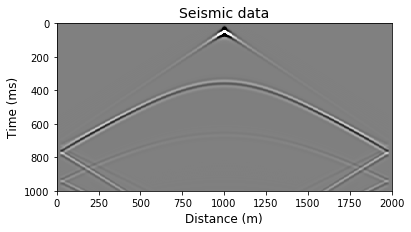

In [18]:
amax = np.max(np.abs(fff[:,5,:].T))
plt.figure()
plt.imshow(fff[:,5,:].T,cmap='gray',extent=[0,Lx,dt*nt*1000,0],vmin=-0.1*amax,vmax=0.1*amax)
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Time (ms)',fontsize=12)
plt.title('Seismic data',fontsize=14)
plt.show()

**Figure 11.  Surface seismic data from the wavefield animation shown in Figure 10.  We observe the direct and reflected arrivals.**

Let's now create a velocity model with a lot more spatial variations. For this example, I'm going to import an image from the **skimage** package, convert it to float, scale it by $1000\times$, and add it to a background velocity of $1500$ m/s. **(Note: you may need to install the scikit-image package to run this example, the command for which is given below.)** The result is shown in Figure 12 below:

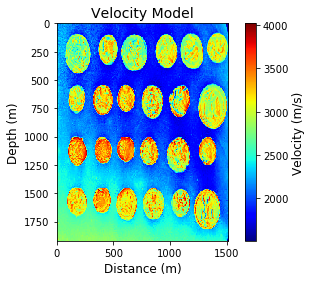

In [19]:
from imageio import imread
testin = imread('https://raw.githubusercontent.com/scikit-image/scikit-image/v0.10.1/skimage/data/coins.png')
test = testin.astype(float)

## . . Define model dimensions
nx,ny = np.size(test,0),np.size(test,1)
dx,dy=5,5
Lx = (nx-1)*dx
Ly = (ny-1)*dy

## . . Define velocity model
newvel = np.zeros((nx,ny))
newvel = 1500+10*test[::-1,:]

plt.figure()
plt.title('Velocity Model',fontsize=14)
plt.imshow(newvel, cmap=plt.cm.jet,extent=[0,nx*dx,ny*dy,0])
plt.xlabel('Distance (m)',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)
cbar=plt.colorbar()
cbar.set_label('Velocity (m/s)',fontsize=12)
plt.show()

**Figure 12. A whimsical velocity model made from the *coins* image in the skimage tool kit.**

Let's now rerun the wave propagation simulation for heterogeneous media from above, but using this new velocity model!

In [20]:
## . . Init wavefields on spatial grid
UUo,UUm  = np.zeros((nx,ny)),np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 500                     # . . Number of time steps
dt = CC*dx/np.max(newvel)    # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift 

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = (1-((t-t0)/ss)**2)*np.exp(-(t-t0)**2/(2*ss**2))

## . . Define source location
sx,sy=Lx/2,Ly/2                # . . source x,y location (in physical m units)

## . . Total Solution space
ggg = np.zeros((nx,ny,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,newvel,F,it,sx,sy) #calc solution at n+1
    ggg[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

## . . compute maximum for scaling
amax = np.max(np.abs(ggg))

In [21]:
vscale = (newvel.T-np.mean(newvel))
vscale = -vscale/np.max(vscale)

def AWE_2D_animate(i):
    global k
    wfld = ggg[:,:,k].T/np.max(np.abs(ggg))
    data = wfld+0.02*vscale[:,::-1]
    ax1.clear()
    ax1.imshow(data,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.08,vmax=0.08)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('2D AWE Step %s'%k,fontsize=14)
    k += kskip

## . . Animate Solution and compute error
k,kskip = 0,5

## . . Set up movie
fig8,ax1 = plt.subplots(1)
fig8.subplots_adjust(0.1,0.1,0.9,0.9)
fig8.set_dpi(100)

## . . Call the animator
anim8 = animation.FuncAnimation(fig8,AWE_2D_animate,frames=int((nt-2*kskip)/kskip),interval=75)
anim8.save('./movies/Ex8_8.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_8.mp4" type="video/mp4">
</video>
""")

**Figure 13. 2D Acoustic wave propagation through velocity model shown in Figure 12.**

# Time-reversal acoustics

One of the most important features of the acoustic wave equation (and hyperbolic PDEs in general) is that one can time reverse the wave propagation (but it gets complicated at the boundary) from maximum time back to zero time.  This is due to the analytical PDE operator being [self-adjoint](https://en.wikipedia.org/wiki/Self-adjoint_operator). (In principle, this does not mean that the numerical implementation is necessarily self-adjoint; one needs to ensure that this is so by applying a [dot-product test](http://sepwww.stanford.edu/sep/prof/bei/conj/paper_html/node11.html)).

To illustrate this principle, we can use the last two time-steps of the wavefield generated from the previous example which we'll call $\psi^n_i$. Let's initialize the present time-reverse wavefield simulation using:

$$\phi^0_i = \psi^{nt-2}_i \tag{26}$$

and

$$\phi^{-1}_i = \psi^{nt-1}_i \tag{27}$$

where you should note reverse ordering of $[-1,0]$ for $\phi$ and $[nt-1,nt-2]$ for $\psi$. Let's rerun the simulation from above **but this time not inject any source term $F(x) = F_{i,j}=0$**.

In [22]:
## . . Init wavefields on spatial grid
UUp,UUo,UUm  = np.zeros((nx,ny)),np.zeros((nx,ny)),np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 450                     # . . Number of time steps
dt = CC*dx/np.max(newvel)    # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time line
t0 = 0.05                    # . . Wavelet shift 

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet
F = np.zeros((nt))

## . . Define source location
sx,sy=Lx/2,Ly/2                # . . source x,y location (in physical m units)

## . . Define initial wavefields for time reversal
UUo = ggg[:,:,nt-2]
UUm = ggg[:,:,nt-1]

## . . Total Solution space
hhh = np.zeros((nx,ny,nt)) 

## . . Iterate over solution
for it in range(nt):
    tmp = awe_2d_explicit_solver_heterogeneous_8th_order(UUo,UUm,dx,dy,dt,newvel,F,it,sx,sy) #calc solution at n+1
    hhh[:,:,it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

Let's now compute the animation of the time-reversing acoustic wavefield through the same velocity model.

In [23]:
## . . compute maximum for scaling
amax = np.max(np.abs(hhh))
vscale = (newvel.T-np.mean(newvel))
vscale = -vscale/np.max(vscale)

def AWE_2D_animate2(i):
    global k
    wfld = hhh[:,:,k].T/amax
    data = wfld+0.02*vscale[:,::-1]
    ax1.clear()
    ax1.imshow(data,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.08,vmax=0.08)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('2D AWE Step %s'%k,fontsize=14)
    k += kskip

## . . Animate Solution and compute error
k,kskip = 0,5

## . . Set up movie
fig9,ax1 = plt.subplots(1)
fig9.subplots_adjust(0.1,0.1,0.9,0.9)
fig9.set_dpi(100)

## . . Call the animator
anim9 = animation.FuncAnimation(fig9,AWE_2D_animate2,frames=int((nt-2*kskip)/kskip),interval=75)
anim9.save('./movies/Ex8_9.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_9.mp4" type="video/mp4">
</video>
""")

**Figure 14. Movie showing time-reverse propagation of that shown in Figure 12 above.**



In [24]:
def awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dy,dt,v,D,it,ry):
    '''Set up eight-order solver of the acoustic wave equation
    usage: U=awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dy,dt,v,D,it,ry):
    input: 
        Uo: Acoustic pressure vector (nx,ny) at time step n
        Um: Acoustic pressure vector (nx,ny) at time step n-1
        dx: Spatial sampling in x
        dy: Spatial sampling in y        
        dt: Temporal sampling
        v : Heterogeneous propagation velocity (nx,ny)
        D : Data to be time reversed
        it: Time index
        ry: Injection depth (meters)
    output:
        Um: Acoustic pressure vector (nx,ny) at time n+1
    dependencies:
        None
    written by Jeff Shragge, jshragge@mines.edu, 10/2019
    '''        
    ## . . Get dimensions of wavefield
    nx,ny = np.size(UUo,0),np.size(UUo,1)
    
    ## . . Define Courant numbers (squared)
    dtdx2 = (dt/dx)**2
    dtdy2 = (dt/dy)**2
        
    ## Source location
    iry = int(ry/dy) ## . . Force to be integer
 
    ## . . Inject wavelet
    UUo[:,iry] += dt*dt*D[:,it]

    ## . . Update solution 
    UUm[4:nx-4,4:ny-4] =  2*UUo[4:nx-4,4:ny-4]-UUm[4:nx-4,4:ny-4]+dtdx2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[0:nx-8,4:ny-4] 
                    +8/315 *UUo[1:nx-7,4:ny-4]  
                    -1/5   *UUo[2:nx-6,4:ny-4]  
                    +8/5   *UUo[3:nx-5,4:ny-4]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[5:nx-3,4:ny-4]  
                    -1/5   *UUo[6:nx-2,4:ny-4]  
                    +8/315 *UUo[7:nx-1,4:ny-4]  
                    -1/560 *UUo[8:nx  ,4:ny-4])+dtdy2*v[4:nx-4,4:ny-4]**2*( 
                    -1/560 *UUo[4:nx-4,0:ny-8] 
                    +8/315 *UUo[4:nx-4,1:ny-7]  
                    -1/5   *UUo[4:nx-4,2:ny-6]  
                    +8/5   *UUo[4:nx-4,3:ny-5]  
                    -205/72*UUo[4:nx-4,4:ny-4]  
                    +8/5   *UUo[4:nx-4,5:ny-3]  
                    -1/5   *UUo[4:nx-4,6:ny-2]  
                    +8/315 *UUo[4:nx-4,7:ny-1]  
                    -1/560 *UUo[4:nx-4,8:ny  ])

    return UUm ## . . Return updated wavefield at time step n+1

In [25]:
## . . Define spatial grid
Lx,Ly = 2000,1200        # . . length (m)
nx,ny = 401,241      # . . Number of points in discretization 
dx = Lx/(nx-1) # . . Discretization interval
dy = Ly/(ny-1) # . . Discretization interval

## . . Create velocity function
v = np.zeros((nx,ny))+1500
v[:,50:]=2000

## . . Init wavefields on spatial grid
UUp = np.zeros((nx,ny))
UUo = np.zeros((nx,ny))
UUm = np.zeros((nx,ny))

## Time stepping parameters
CC = 0.5                     # . . Courant #
nt = 800                     # . . Number of time steps
dt = CC*dx/np.max(v)         # . . Define dt based on Courant
t  = np.linspace(0,nt*dt,nt) # . . Time lin
t0 = 0.05                    # . . Wavelet shift 

## . . Define forcing function
ss=0.01                      # . . sigma for Ricker wavelet

## . . Get the data from fff above
data = fff[:,5,:]

## . . Define source location
ry=25                        # . . receiver injection location in y (in physical m units)

## . . Total Solution space
mmm = np.zeros((nx,ny,nt)) 

## . . Iterate over solution
## . . Note time reversal
for it in range(nt-1,0,-1):
    tmp = awe_2d_heterogeneous_8th_order_data_time_reverse(UUo,UUm,dx,dy,dt,v,data,it,ry) #calc solution at n+1
    mmm[:,:,nt-1-it]=tmp  ## save solution vector
    UUm=UUo          ## move solution at n to n-1 to prepare for next iteration
    UUo=tmp          ## move solution at n+1 to n to prepare for next iteration

In [26]:
## . . compute maximum for scaling
amax = np.max(np.abs(mmm))
vscale = (v.T-np.mean(v))
vscale = -vscale/np.max(vscale)

def AWE_2D_animate3(i):
    global k
    wfld = mmm[:,:,k].T/amax
    data = wfld+0.0025*vscale[:,::-1]
    ax1.clear()
    ax1.imshow(data,cmap='gray',extent=[0,Lx,0,Ly],vmin=-0.08,vmax=0.08)
    ax1.set(xlabel='X(m)', ylabel='Y(m)')
    ax1.set_title('2D AWE Step %s'%k,fontsize=14)
    k += kskip

## . . Animate Solution and compute error
k,kskip = 0,5

## . . Set up movie
fig10,ax1 = plt.subplots(1)
fig10.subplots_adjust(0.1,0.1,0.9,0.9)
fig10.set_dpi(100)

## . . Call the animator
anim10 = animation.FuncAnimation(fig10,AWE_2D_animate3,frames=int((nt-2*kskip)/kskip),interval=75)
anim10.save('./movies/Ex8_10.mp4')
plt.close()

HTML("""
<video width="800" controls style="display:block; margin:0 auto;">
  <source src="./movies/Ex8_10.mp4" type="video/mp4">
</video>
""")

**Figure 15.  Movie showing the time-reverse behavior in the layered half-space model.**